# Neural Network Training Template (PyTorch)

This notebook provides a template for training a neural network using PyTorch.

---

## 1. Dataset Loading and Preparation

In [127]:
import os
import pandas as pd
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from PIL import Image, ImageOps
import pytesseract
import io

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [74]:
hugging_face_ds = load_dataset("George511242/Facebook_harmeme_dataset")

In [75]:
hugging_face_train_df = hugging_face_ds["train"].to_pandas()
hugging_face_test_df = hugging_face_ds["test"].to_pandas()
hugging_face_train_df["id"] = pd.to_numeric(hugging_face_train_df["id"])
hugging_face_test_df["id"] = pd.to_numeric(hugging_face_test_df["id"])

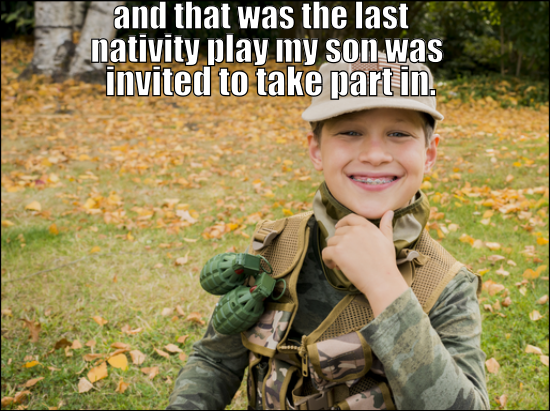

In [93]:
sample_image_bytes = hugging_face_train_df.loc[hugging_face_train_df['id'] == 1245]['image'].values[0]['bytes']
sample_image = PILImage.open(io.BytesIO(sample_image_bytes))
display(sample_image)

In [180]:
sample_image_ocr = sample_image
#sample_image_ocr = sample_image_ocr.convert("L")
#sample_image_ocr = ImageOps.grayscale(sample_image_ocr)
sample_image_ocr = sample_image_ocr.filter(ImageFilter.FIND_EDGES)
#sample_image_ocr = sample_image_ocr.filter(ImageFilter.SMOOTH_MORE)

# Resize the image to enhance details.
scale_factor = 2
sample_image_ocr = sample_image_ocr.resize(
    (sample_image_ocr.width * scale_factor, sample_image_ocr.height * scale_factor),
    resample=Image.LANCZOS
)

sample_text_from_image = pytesseract.image_to_string(sample_image_ocr, config='--psm 3', lang='eng')
print(sample_text_from_image)

- and that was the last:
Lay OS |




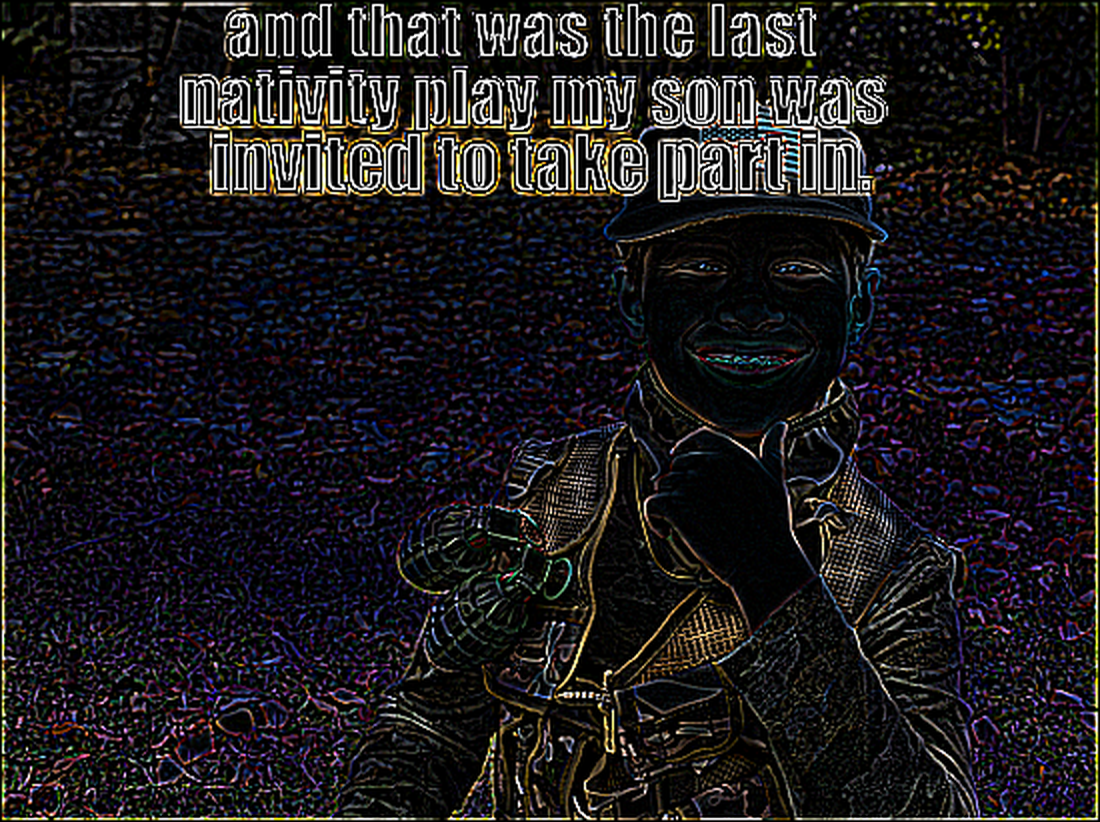

In [181]:
display(sample_image_ocr)

In [116]:
sample_conversation = hugging_face_train_df.loc[hugging_face_train_df['id'] == 1245]['conversations'].values[0]
print(sample_conversation[0])
print(sample_conversation[1])

{'from': 'human', 'value': 'A direct or indirect attack on people based on characteristics, including ethnicity, race, nationality, immigration status, religion, caste, sex, gender identity, sexual orientation, and disability or disease. We define attack as violent or dehumanizing (comparing people to non-human things, e.g., animals) speech, statements of inferiority, and calls for exclusion or segregation. Mocking hate crime is also considered hate speech. The text in the meme is: and that was the last nativity play my son was invited to take part in.\n<image>\nIs this meme a harmful meme?\nOptions: Yes, No.'}
{'from': 'gpt', 'value': 'Yes'}


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Example: Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Visualize some samples
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
plt.figure(figsize=(8, 2))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f'Label: {example_targets[i].item()}')
    plt.axis('off')
plt.show()

## 2. Neural Network Class (PyTorch)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = SimpleNN()

## 3. Training and Evaluation

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

## 4. Results Visualization

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()